<a href="https://colab.research.google.com/github/gerardtomaszewski/ml_w_finansach/blob/main/case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('case1.csv', delimiter=';', index_col= 0)
df.head()

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [4]:
df_filtered = df.iloc[:, 3:-2]
data_filled = df.fillna(df_filtered.median())
data_filled = data_filled.iloc[:,2:]

categories = data_filled.select_dtypes('O')

for col in categories:
    data_filled[col] = data_filled[col].replace(' ', 'None')
    data_filled[col] = data_filled[col].fillna('None')


categorical_columns = data_filled.iloc[:,1:].select_dtypes(include=['object']).columns
numerical_columns = data_filled.iloc[:,1:].select_dtypes(include=['number']).columns

no_var = data_filled[numerical_columns].var() == 0

data_filled = data_filled.drop(data_filled[numerical_columns].var()[no_var].index, axis = 1)
numerical_columns = data_filled.iloc[:,1:].select_dtypes(include=['number']).columns

data_filled.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0,Cofoundit,Numeraire
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0,Livepeer Token,Livepeer Token
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0,None,XENON
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0,Raiden,XENON
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0,StatusNetwork,EOS


In [5]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(data_filled[numerical_columns])

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(data_filled[categorical_columns])

scaled_data = pd.DataFrame(scaled_numerical, columns=numerical_columns)
scaled_data = pd.concat([data_filled['FLAG'], scaled_data], axis=1)


In [6]:
correlation_matrix = scaled_data.select_dtypes(include=['number']).corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
scaled_data = scaled_data.drop(to_drop, axis=1)

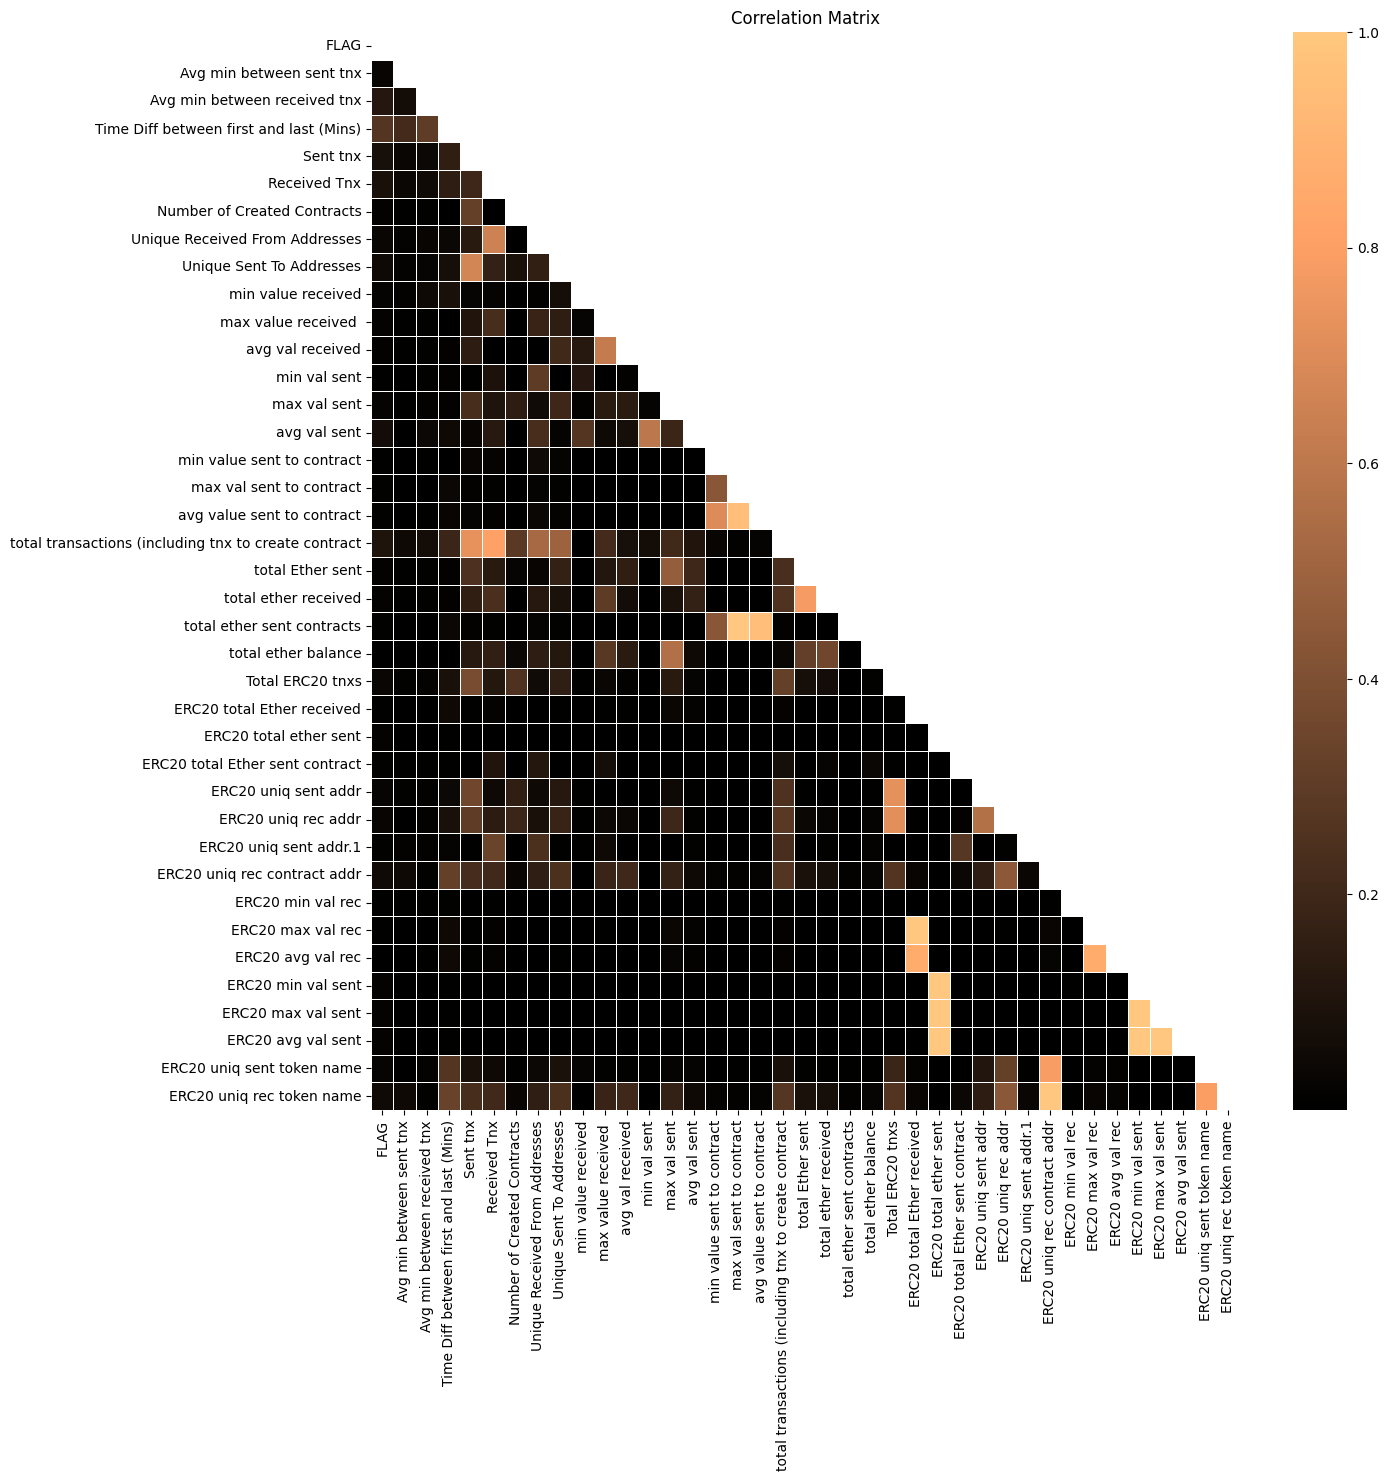

In [7]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, mask=mask, cmap='copper', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [8]:
encoded_categorical_df = pd.DataFrame(encoded_categorical.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
scaled_data = pd.concat([scaled_data, encoded_categorical_df], axis=1)

In [9]:
y = scaled_data['FLAG']
x = scaled_data.iloc[:,1:]

pca = PCA(n_components=10)
pca_data = pca.fit_transform(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(pca_data, y, test_size = 0.2, random_state = 123)

oversampler = SMOTE()
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [10]:
LR = LogisticRegression(random_state=42)
LR.fit(X_resampled, y_resampled)

preds = LR.predict(X_test)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))


              precision    recall  f1-score   support

           0       0.97      0.85      0.90      1547
           1       0.62      0.90      0.73       422

    accuracy                           0.86      1969
   macro avg       0.79      0.87      0.82      1969
weighted avg       0.89      0.86      0.87      1969

[[1311  236]
 [  42  380]]


In [11]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_resampled, y_resampled)
preds_RF = RF.predict(X_test)

print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1547
           1       0.91      0.91      0.91       422

    accuracy                           0.96      1969
   macro avg       0.95      0.95      0.95      1969
weighted avg       0.96      0.96      0.96      1969

[[1511   36]
 [  36  386]]


In [12]:
xgb_c = xgb.XGBClassifier(random_state=42)
xgb_c.fit(X_resampled, y_resampled)
preds_xgb = xgb_c.predict(X_test)

print(classification_report(y_test, preds_xgb))
print(confusion_matrix(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1547
           1       0.91      0.92      0.92       422

    accuracy                           0.96      1969
   macro avg       0.95      0.95      0.95      1969
weighted avg       0.96      0.96      0.96      1969

[[1510   37]
 [  34  388]]


In [13]:
params_grid = {'learning_rate':[0.01, 0.1, 0.5],
              'n_estimators':[100,200],
              'subsample':[0.5, 0.9],
               'max_depth':[3,4],
               'colsample_bytree':[0.3,0.7]}

grid = GridSearchCV(estimator=xgb_c, param_grid=params_grid, scoring='recall', cv = 10, verbose = 0)

grid.fit(X_resampled, y_resampled)
print(f'Best params found for XGBoost are: {grid.best_params_}')
print(f'Best recall obtained by the best params: {grid.best_score_}')

preds_best_xgb = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, preds_best_xgb))
print(confusion_matrix(y_test, preds_best_xgb))

Best params found for XGBoost are: {'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Best recall obtained by the best params: 0.9790649101975761
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1547
           1       0.90      0.94      0.92       422

    accuracy                           0.96      1969
   macro avg       0.94      0.95      0.95      1969
weighted avg       0.97      0.96      0.97      1969

[[1505   42]
 [  27  395]]


Random Forest oraz XGBoost dały podobnie wyniki, aczkolwiek XGBoost z doborem hiperparametrów okazał się najlepszy ponieważ miał najmniejszy wynik False Negative - chcemy odkryć jak najwięcej oszustw.